In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
fm = flopy.modflow

%matplotlib inline

flopy is installed in C:\Users\votercb\AppData\Local\conda\conda\envs\pyclass\lib\site-packages\flopy


## Set parameters

In [2]:
# inputs
namefile = 'lpr_inset.nam'
model_ws = 'data/lpr_inset'
listingfile = '{}/lpr_inset.list'.format(model_ws)
gagefile = '{}/5400625lpr.ggo'.format(model_ws)
start_datetime = '2014-01-01'

# outputs
output_folder = os.path.join(model_ws, 'postproc')

## Load model

In [3]:
m = fm.Modflow.load(namefile, model_ws = model_ws,
                   #load_only = ['DIS']
                   )
m

MODFLOW 3 layer(s) 137 row(s) 171 column(s) 12 stress period(s)

## Visualize K field

In [4]:
m.get_package_list()

['DIS', 'BAS6', 'UPW', 'RCH', 'OC', 'SFR', 'GAGE', 'WEL', 'HYD', 'NWT', 'CHD']

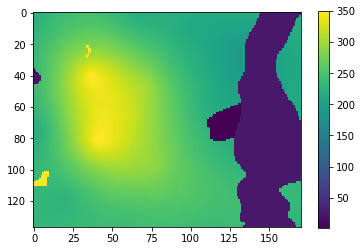

In [5]:
plt.imshow(m.upw.hk.array[0], vmax = 350) #from the UPW package, get hk (hydraulic cond field, I think) as a numpy array
plt.colorbar()

In [6]:
m.upw.hk.data_type

<DataType.array3d: 2>

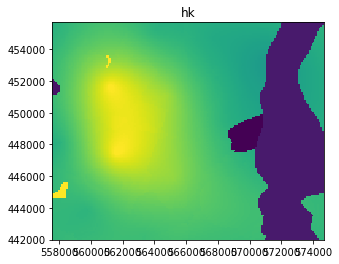

In [7]:
# Plotting this way reads in coord info from the name file and adjusts x-y coords to reflect that
# Unfortunately, they're too big - not in WTM coords
# Model is in feet, coordinate system is in meters. Need to adjust model grid to plot right.
m.upw.hk[0].plot(vmax = 350)

In [8]:
m.dis.delc.array[0]

100.0

In [9]:
m.modelgrid.delc[0] # should be 30.48 because we want to plot in WTM, not model coordinates

100.0

In [10]:
from flopy.discretization import StructuredGrid

grid = StructuredGrid(xoff = 557570.748, 
                      yoff = 441990.238,
                      proj4 = 'epsg:3070',
                      delr = np.ones(m.ncol)*30.48,
                      delc = np.ones(m.nrow)*30.48)
grid

xll:557570.748; yll:441990.238; rotation:0.0; proj4_str:+init=epsg:3070; units:undefined; lenuni:0

In [11]:
m.modelgrid = grid

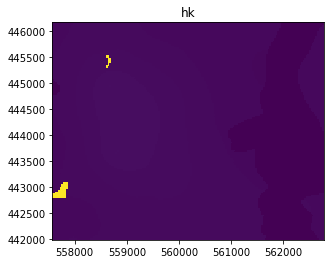

In [12]:
m.upw.hk[0].plot() # now the model has the correct number of meters on the x and y access

In [13]:
m.rch.rech.array.shape

(12, 1, 137, 171)

In [14]:
m.rch.rech.data_type

<DataType.transient2d: 3>

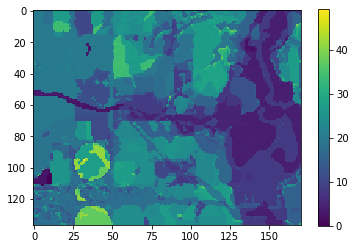

In [15]:
# Average recharge in inches across the model
r_in = m.rch.rech.array[:, 0, :, :]*12
plt.imshow(r_in.sum(axis = 0)*30.4)
plt.colorbar() 

<BarContainer object of 12 artists>

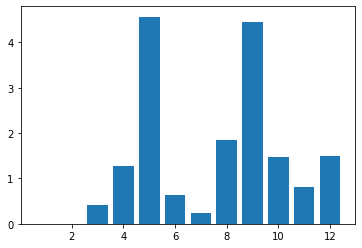

In [16]:
plt.bar(range(1, 13), r_in.mean(axis = (1,2))*30.4) #Gives us the spatial mean for each month

In [17]:
m.exe_name = '../../executables/mfnwt.exe'
m.run_model()

FloPy is using the following  executable to run the model: ../../executables/mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.4 4/01/2018                         
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: lpr_inset.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/11/21 13:49:31

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Groundwater-Flow Eqn.

(True, [])

In [18]:
gagefile

'data/lpr_inset/5400625lpr.ggo'

In [19]:
with open(gagefile) as src:
    print(src.read())

 "GAGE No.    1:  K,I,J Coord. =     1,   62,   51;  STREAM SEGMENT =    11;  REACH =    56 "
     "DATA: Time           Stage            Flow"
     4.1657705E+00   1.0764440E+03   3.8656219E+05
     9.1646957E+00   1.0764413E+03   3.5220169E+05
     1.5163405E+01   1.0764233E+03   3.2404284E+05
     2.2361858E+01   1.0764089E+03   3.0106838E+05
     3.1000000E+01   1.0763965E+03   2.8112416E+05
     3.4762630E+01   1.0763883E+03   2.7138850E+05
     3.9277786E+01   1.0763834E+03   2.6349725E+05
     4.4695976E+01   1.0763783E+03   2.5524669E+05
     5.1197803E+01   1.0763729E+03   2.4651675E+05
     5.8999996E+01   1.0763673E+03   2.3759888E+05
     6.3165768E+01   1.0763638E+03   2.3449459E+05
     6.8164696E+01   1.0763627E+03   2.3302208E+05
     7.4163406E+01   1.0763617E+03   2.3142295E+05
     8.1361862E+01   1.0763606E+03   2.2969358E+05
     9.0000008E+01   1.0763594E+03   2.2783664E+05
     9.4031395E+01   1.0763607E+03   2.3309466E+05
     9.8869064E+01   1.0763652E+03   2.3

In [20]:
ggo = pd.read_csv(gagefile, header = None, skiprows = 1,
                 delim_whitespace = True,
                 names = ['time', 'stage', 'flow'])

In [21]:
ggo.head()

,time,stage,flow
0,4.165770,1076.4440,386562.19
1,9.164696,1076.4413,352201.69
2,15.163405,1076.4233,324042.84
3,22.361858,1076.4089,301068.38
4,31.000000,1076.3965,281124.16


In [22]:
# get time into real datetimes (from days since start of simulation)
start_datetime

'2014-01-01'

In [23]:
start_ts = pd.Timestamp(start_datetime)
start_ts

Timestamp('2014-01-01 00:00:00')

In [24]:
ggo['datetime'] = pd.to_timedelta(ggo.time, unit = 'D').head() + start_ts
ggo.index = ggo.datetime
ggo.head()

,time,stage,flow,datetime
datetime,,,,
2014-01-05 03:58:42.571199999,4.165770,1076.4440,386562.19,2014-01-05 03:58:42.571199999
2014-01-10 03:57:09.708480000,9.164696,1076.4413,352201.69,2014-01-10 03:57:09.708480000
2014-01-16 03:55:18.192000000,15.163405,1076.4233,324042.84,2014-01-16 03:55:18.192000000
2014-01-23 08:41:04.531200000,22.361858,1076.4089,301068.38,2014-01-23 08:41:04.531200000
2014-02-01 00:00:00.000000000,31.000000,1076.3965,281124.16,2014-02-01 00:00:00.000000000


In [25]:
m.dis.nstp.array

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [35]:
kstp = []
kper = []
for i, nstp in enumerate(m.dis.nstp.array):
    for j in range(nstp):
        kstp.append(j)
        kper.append(i)
len(kstp)

60

In [38]:
ggo['kstp'] = kstp
ggo['kper'] = kper
ggo.head()

,time,stage,flow,datetime,kstp,kper
datetime,,,,,,
2014-01-05 03:58:42.571199999,4.165770,1076.4440,386562.19,2014-01-05 03:58:42.571199999,0,0
2014-01-10 03:57:09.708480000,9.164696,1076.4413,352201.69,2014-01-10 03:57:09.708480000,1,0
2014-01-16 03:55:18.192000000,15.163405,1076.4233,324042.84,2014-01-16 03:55:18.192000000,2,0
2014-01-23 08:41:04.531200000,22.361858,1076.4089,301068.38,2014-01-23 08:41:04.531200000,3,0
2014-02-01 00:00:00.000000000,31.000000,1076.3965,281124.16,2014-02-01 00:00:00.000000000,4,0


In [39]:
ggo.head()

,time,stage,flow,datetime,kstp,kper
datetime,,,,,,
2014-01-05 03:58:42.571199999,4.165770,1076.4440,386562.19,2014-01-05 03:58:42.571199999,0,0
2014-01-10 03:57:09.708480000,9.164696,1076.4413,352201.69,2014-01-10 03:57:09.708480000,1,0
2014-01-16 03:55:18.192000000,15.163405,1076.4233,324042.84,2014-01-16 03:55:18.192000000,2,0
2014-01-23 08:41:04.531200000,22.361858,1076.4089,301068.38,2014-01-23 08:41:04.531200000,3,0
2014-02-01 00:00:00.000000000,31.000000,1076.3965,281124.16,2014-02-01 00:00:00.000000000,4,0


In [41]:
ggo_last = ggo.groupby(ggo.kper).last()
ggo_last.index = ggo_last.datetime
ggo_last

,time,stage,flow,datetime,kstp
datetime,,,,,
2014-02-01,31.000000,1076.3965,281124.16,2014-02-01,4
NaT,58.999996,1076.3673,237598.88,NaT,4
NaT,90.000008,1076.3594,227836.64,NaT,4
NaT,120.000020,1076.3799,263181.75,NaT,4
NaT,151.000020,1076.4760,444835.56,NaT,4
NaT,181.000020,1076.4280,330844.44,NaT,4
NaT,212.000020,1076.3630,224378.22,NaT,4
NaT,243.000020,1076.3694,248576.53,NaT,4
NaT,273.000000,1076.4595,412836.53,NaT,4


In [32]:
df = pd.read_csv('data/lpr_inset/05400625.txt', skiprows = 30, header = None, sep = '\t')
df.index = pd.to_datetime(df[2])
df.head()

,0,1,2,3,4,5
2,,,,,,
2014-03-18 00:00:00,USGS,5400625,2014-03-18 00:00,CDT,1.91,A
2014-03-18 00:15:00,USGS,5400625,2014-03-18 00:15,CDT,1.98,A
2014-03-18 00:30:00,USGS,5400625,2014-03-18 00:30,CDT,1.98,A
2014-03-18 00:45:00,USGS,5400625,2014-03-18 00:45,CDT,1.98,A
2014-03-18 01:00:00,USGS,5400625,2014-03-18 01:00,CDT,1.98,A


In [34]:
ggo_last['flow_cfs'] = ggo_last['flow']/86400
ggo_last.head()

,time,stage,flow,datetime,kstp,flow_cfs
kper,,,,,,
0,31.000000,1076.3965,281124.16,2014-02-01,4,3.253752
1,58.999996,1076.3673,237598.88,NaT,4,2.749987
2,90.000008,1076.3594,227836.64,NaT,4,2.636998
3,120.000020,1076.3799,263181.75,NaT,4,3.046085
4,151.000020,1076.4760,444835.56,NaT,4,5.148560


C:\Users\votercb\AppData\Local\conda\conda\envs\pyclass\lib\site-packages\pandas\plotting\_matplotlib\core.py:1085: UserWarning: Attempting to set identical left == right == 735265.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


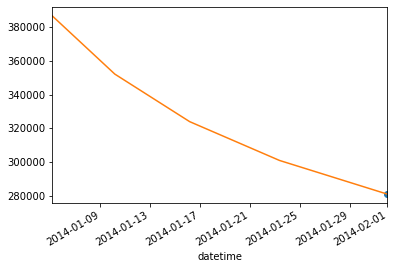

In [42]:
ax = ggo_last.flow.plot(marker='o')
ggo.flow.plot(ax=ax)

In [43]:
from flopy.utils import MfListBudget

In [44]:
mfl = MfListBudget(listingfile)
mfl

In [47]:
df_flux, df_vol = mfl.get_dataframes(start_datetime = start_datetime)

In [49]:
df_flux

,STORAGE_IN,CONSTANT_HEAD_IN,WELLS_IN,RECHARGE_IN,STREAM_LEAKAGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,WELLS_OUT,RECHARGE_OUT,STREAM_LEAKAGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
2014-02-01,4.264926e+05,6.469874e+05,0.0,4.471989e+02,555.530518,1074482.750,0.000000e+00,394497.15625,8.155048e+04,0.0,598601.3750,1074649.000,-166.250,-0.02
2014-03-01,4.834691e+05,6.166172e+05,0.0,4.410000e+02,1439.527466,1101966.750,0.000000e+00,502048.40625,7.135764e+04,0.0,528673.3125,1102079.375,-112.625,-0.01
2014-04-01,1.988454e+05,6.208312e+05,0.0,2.617255e+05,1598.823853,1083001.125,1.075373e+03,494819.87500,7.398868e+04,0.0,513919.3125,1083803.250,-802.125,-0.07
2014-05-01,1.326638e+04,6.350020e+05,0.0,7.910498e+05,669.892212,1439988.000,4.185641e+05,384565.34375,6.967979e+04,0.0,567054.6250,1439863.750,124.250,0.01
2014-06-01,0.000000e+00,1.154976e+06,0.0,2.851267e+06,0.000000,4006243.000,2.526834e+06,307455.37500,3.036795e+05,0.0,868731.3750,4006700.500,-457.500,-0.01
2014-07-01,8.636718e+05,8.602034e+05,0.0,4.002594e+05,52.092701,2124186.750,1.906261e+05,298184.90625,9.566822e+05,0.0,678839.1875,2124332.500,-145.750,-0.01
2014-08-01,1.510960e+06,7.345469e+05,0.0,1.476533e+05,1733.088867,2394893.750,0.000000e+00,561162.93750,1.300218e+06,0.0,533689.5000,2395070.250,-176.500,-0.01
2014-09-01,1.280915e+05,6.749704e+05,0.0,1.151700e+06,953.063477,1955715.250,4.959043e+05,404641.25000,4.675548e+05,0.0,587514.0625,1955614.250,101.000,0.01
2014-10-01,0.000000e+00,7.596164e+05,0.0,2.769532e+06,0.000000,3529148.500,2.039554e+06,360912.43750,2.601890e+05,0.0,868702.7500,3529358.000,-209.500,-0.01
2014-11-01,9.572029e+03,1.131134e+06,0.0,9.202642e+05,0.000000,2060970.500,8.618438e+05,227386.37500,1.284196e+05,0.0,843406.3125,2061056.000,-85.500,-0.00


In [50]:
# see other notebook for fancy bar chart

In [52]:
from flopy.utils import HydmodObs

In [57]:
hydobj = HydmodObs('{}/{}.hyd.bin'.format(m.model_ws, m.name))
hyd = pd.DataFrame(hydobj.get_data()) # pandas can take recarrays and do stuff
hyd

,totim,HDI00100910042_uwsp,HDI00200910042_uwsp,HDI00300910042_uwsp,HDI00100940041_uwsp,HDI00200940041_uwsp,HDI00300940041_uwsp,HDI0012309e1803_uwsp,HDI0022309e1803_uwsp,HDI0032309e1803_uwsp,...,HDI0032900089303001,HDI0012908089294701,HDI0022908089294701,HDI0032908089294701,HDI0012909089311801,HDI0022909089311801,HDI0032909089311801,HDI0012915089302001,HDI0022915089302001,HDI0032915089302001
0,0.000000,1076.331665,1076.324951,1076.324951,1074.555908,1074.627930,1074.627930,1077.633057,1077.529053,1077.529053,...,1075.167480,1076.731567,1076.729126,1076.729126,1073.711182,1073.710938,1073.710938,1075.585571,1075.584961,1075.584961
1,4.165771,1076.173828,1076.160034,1076.159546,1074.567261,1074.649658,1074.652466,1077.837646,1077.839600,1077.839600,...,1075.188965,1076.689819,1076.683472,1076.683228,1073.570679,1073.551636,1073.550903,1075.552734,1075.546265,1075.546021
2,9.164696,1076.102295,1076.097534,1076.097290,1074.571899,1074.650879,1074.653564,1077.921875,1077.915771,1077.915527,...,1075.169312,1076.648071,1076.643066,1076.642822,1073.514282,1073.504883,1073.504517,1075.498779,1075.492676,1075.492432
3,15.163405,1076.072510,1076.071411,1076.071411,1074.565063,1074.640869,1074.643433,1077.928833,1077.916748,1077.916382,...,1075.138184,1076.591431,1076.585815,1076.585693,1073.491211,1073.483887,1073.483521,1075.436646,1075.430664,1075.430420
4,22.361858,1076.058350,1076.058472,1076.058472,1074.549561,1074.622192,1074.624634,1077.895264,1077.880981,1077.880493,...,1075.096436,1076.515991,1076.510132,1076.509888,1073.474487,1073.467285,1073.467041,1075.366211,1075.360474,1075.360229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,338.165833,1078.347778,1078.339478,1078.339233,1075.917358,1076.037354,1076.041382,1079.465210,1079.452515,1079.452026,...,1076.502075,1077.829712,1077.818726,1077.818237,1075.202271,1075.197144,1075.196899,1076.727783,1076.715820,1076.715454
57,343.164764,1078.416748,1078.408081,1078.407837,1075.976807,1076.097778,1076.101929,1079.605225,1079.588623,1079.588135,...,1076.564453,1077.900269,1077.889282,1077.888916,1075.240967,1075.235352,1075.235107,1076.783325,1076.771484,1076.770996
58,349.163483,1078.493896,1078.484863,1078.484619,1076.044189,1076.165771,1076.169922,1079.723022,1079.703247,1079.702637,...,1076.634644,1077.978882,1077.967407,1077.967041,1075.286377,1075.280518,1075.280273,1076.848267,1076.836182,1076.835693
59,356.361938,1078.579468,1078.569946,1078.569702,1076.119629,1076.241455,1076.245605,1079.833008,1079.811401,1079.810669,...,1076.711426,1078.062866,1078.050781,1078.050293,1075.339722,1075.333496,1075.333252,1076.920532,1076.908203,1076.907715


In [58]:
from flopy.utils import SfrFile

In [61]:
sfrobj = SfrFile('{}/{}.sfr.out'.format(m.model_ws, m.name))

In [65]:
sfrdata = sfrobj.df.copy()
sfrdata.head()

,layer,row,column,segment,reach,Qin,Qaquifer,Qout,Qovr,Qprecip,Qet,stage,depth,width,Cond,gradient,kstpkper,k,i,j
0,1,64,119,1,1,0.00,-574.790,574.79,0.0,0.0,0.0,1087.15,0.04736,0.6774,163.20,-3.914,"(4, 0)",0,63,118
1,1,64,118,1,2,574.79,-78.274,653.06,0.0,0.0,0.0,1087.10,0.03677,0.7416,22.99,-3.783,"(4, 0)",0,63,117
2,1,63,118,1,3,653.06,-1146.900,1800.00,0.0,0.0,0.0,1087.12,0.09642,0.8419,331.10,-3.848,"(4, 0)",0,62,117
3,1,63,117,1,4,1800.00,-907.060,2707.00,0.0,0.0,0.0,1087.09,0.11940,1.0010,278.30,-3.622,"(4, 0)",0,62,116
4,1,63,116,1,5,2707.00,-962.420,3669.50,0.0,0.0,0.0,1087.05,0.13740,1.1320,314.50,-3.400,"(4, 0)",0,62,115


In [71]:
isvalid = (sfrdata.segment == 11) & (sfrdata.kstpkper == (4, 6)) # recall flopy is zero-based
isvalid

0       False
1       False
2       False
3       False
4       False
        ...  
4264    False
4265    False
4266    False
4267    False
4268    False
Length: 4236, dtype: bool

In [75]:
seg11 = sfrdata.loc[isvalid, ['Qout', 'Qaquifer','segment', 'reach']]
seg11.head()

,Qout,Qaquifer,segment,reach
2303,123920.0,-336.17,11,1
2304,124020.0,-104.45,11,2
2305,124250.0,-228.14,11,3
2306,124600.0,-349.15,11,4
2307,125210.0,-611.69,11,5


In [77]:
rd = pd.DataFrame(m.sfr.reach_data)
rd.head()

,node,k,i,j,iseg,ireach,rchlen,strtop,slope,strthick,strhc1,thts,thti,eps,uhc,reachID,outreach
0,10891,0,63,118,1,1,86.921516,1087.099976,0.000389,0.9,2.493963,0.0,0.0,0.0,0.0,1,2
1,10890,0,63,117,1,2,11.187760,1087.066040,0.003443,0.9,2.493963,0.0,0.0,0.0,0.0,2,3
2,10719,0,62,117,1,3,141.945404,1087.027954,0.000429,0.9,2.493963,0.0,0.0,0.0,0.0,3,4
3,10718,0,62,116,1,4,100.375504,1086.967041,0.000503,0.9,2.493963,0.0,0.0,0.0,0.0,4,5
4,10717,0,62,115,1,5,100.273300,1086.916016,0.000493,0.9,2.493963,0.0,0.0,0.0,0.0,5,6


In [81]:
dist = rd.loc[rd.iseg == 11, 'rchlen'].cumsum().tolist()
seg11.index = dist # normally check to make sure the reaches are in the same order
seg11.head()

,Qout,Qaquifer,segment,reach
117.241302,123920.0,-336.17,11,1
130.049271,124020.0,-104.45,11,2
176.316086,124250.0,-228.14,11,3
231.361160,124600.0,-349.15,11,4
332.673065,125210.0,-611.69,11,5


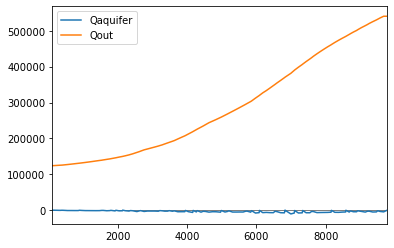

In [84]:
ax = seg11[['Qaquifer', 'Qout']].plot()
ax.axhline(0, color = "k", zorder = -1, lw = 0.5) # shows that groundwater system is losing water to the stream

In [85]:
m.dis.export('{}/lpr_dis.shp'.format(output_folder))

wrote data/lpr_inset\postproc/lpr_dis.shp


In [86]:
m.dis.top.export('{}/lpr_top.shp'.format(output_folder)) #this can get unweildy quickly-this small model still has ~150mb outputs

wrote data/lpr_inset\postproc/lpr_top.shp


In [88]:
import mfexport

In [90]:
with open('data/lpr_inset/lpr_grid.json') as src:
    print(src.read())

{
    "delc": 30.48,
    "delr": 30.48,
    "epsg": 3070,
    "lenuni": 2,
    "nrow": 137,
    "ncol": 171,
    "xul": 557571,
    "yul": 446166
}


In [91]:
grid = mfexport.load_modelgrid('data/lpr_inset/lpr_grid.json')


arguments to MFexportGrid:
delc: [30.48 30.48 30.48 ... 30.48 30.48 30.48]
delr: [30.48 30.48 30.48 ... 30.48 30.48 30.48]
epsg: 3070
lenuni: 2
xul: 557571
yul: 446166

other arguments:
nrow: 137
ncol: 171




In [93]:
mfexport.export(m, grid, output_path = output_folder, pdfs = True, gis = True)

creating data/lpr_inset\postproc\pdfs...
creating data/lpr_inset\postproc\shps...
creating data/lpr_inset\postproc\rasters...

DIS package...
botm:
wrote data/lpr_inset\postproc\rasters\botm_lay0.tif
wrote data/lpr_inset\postproc\rasters\botm_lay1.tif
wrote data/lpr_inset\postproc\rasters\botm_lay2.tif
thickness:
wrote data/lpr_inset\postproc\rasters\thickness_lay0.tif
wrote data/lpr_inset\postproc\rasters\thickness_lay1.tif
wrote data/lpr_inset\postproc\rasters\thickness_lay2.tif
model_top:
wrote data/lpr_inset\postproc\rasters\model_top.tif

BAS6 package...
ibound:
wrote data/lpr_inset\postproc\rasters\ibound_lay0.tif
wrote data/lpr_inset\postproc\rasters\ibound_lay1.tif
wrote data/lpr_inset\postproc\rasters\ibound_lay2.tif
strt:
wrote data/lpr_inset\postproc\rasters\strt_lay0.tif
wrote data/lpr_inset\postproc\rasters\strt_lay1.tif
wrote data/lpr_inset\postproc\rasters\strt_lay2.tif

UPW package...
hani:
wrote data/lpr_inset\postproc\rasters\hani_lay0.tif
wrote data/lpr_inset\postpro

C:\Users\votercb\AppData\Local\conda\conda\envs\pyclass\lib\site-packages\pandas\core\frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


writing data/lpr_inset\postproc\shps\chd_stress_period_data.shp...
shead:
ehead:


['data/lpr_inset\\postproc\\rasters\\botm_lay0.tif',
 'data/lpr_inset\\postproc\\pdfs\\botm_lay0.pdf',
 'data/lpr_inset\\postproc\\rasters\\botm_lay1.tif',
 'data/lpr_inset\\postproc\\pdfs\\botm_lay1.pdf',
 'data/lpr_inset\\postproc\\rasters\\botm_lay2.tif',
 'data/lpr_inset\\postproc\\pdfs\\botm_lay2.pdf',
 'data/lpr_inset\\postproc\\rasters\\thickness_lay0.tif',
 'data/lpr_inset\\postproc\\pdfs\\thickness_lay0.pdf',
 'data/lpr_inset\\postproc\\rasters\\thickness_lay1.tif',
 'data/lpr_inset\\postproc\\pdfs\\thickness_lay1.pdf',
 'data/lpr_inset\\postproc\\rasters\\thickness_lay2.tif',
 'data/lpr_inset\\postproc\\pdfs\\thickness_lay2.pdf',
 'data/lpr_inset\\postproc\\rasters\\model_top.tif',
 'data/lpr_inset\\postproc\\pdfs\\model_top.pdf',
 'data/lpr_inset\\postproc\\rasters\\ibound_lay0.tif',
 'data/lpr_inset\\postproc\\pdfs\\ibound_lay0.pdf',
 'data/lpr_inset\\postproc\\rasters\\ibound_lay1.tif',
 'data/lpr_inset\\postproc\\pdfs\\ibound_lay1.pdf',
 'data/lpr_inset\\postproc\\rasters

In [96]:
mfexport.export(m, grid, output_path = output_folder, pdfs = True, gis = True, packages = 'dis', variables = 'top')


DIS package...
model_top:
wrote data/lpr_inset\postproc\rasters\model_top.tif


['data/lpr_inset\\postproc\\rasters\\model_top.tif',
 'data/lpr_inset\\postproc\\pdfs\\model_top.pdf']

In [97]:
df = mfexport.summarize(m)

summarizing lpr_inset input...


C:\Users\votercb\AppData\Local\conda\conda\envs\pyclass\lib\site-packages\pandas\core\frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [99]:
df #quick way to check for invalid values, e.g. if the model's not converging

,package,variable,layer,min,mean,max,period
0,DIS,botm,0.0,1033.500000,1049.306527,1066.699951,NaN
1,DIS,botm,1.0,991.239990,1004.092457,1063.699951,NaN
2,DIS,botm,2.0,988.239990,1000.740342,1042.599976,NaN
3,DIS,thickness,0.0,21.839966,56.530696,131.650024,NaN
4,DIS,thickness,1.0,3.000000,45.214069,72.649963,NaN
...,...,...,...,...,...,...,...
73,CHD,ehead,NaN,1068.763794,1088.371948,1106.807251,7.0
74,CHD,ehead,NaN,1069.293457,1089.462402,1107.370239,8.0
75,CHD,ehead,NaN,1069.331055,1090.146729,1107.880493,9.0
76,CHD,ehead,NaN,1069.153809,1090.272583,1108.360352,10.0
